# What happens in this notebook :-)

* We read in MC samples for background and different signal models. We also read in the actual data from the L3 detector.

* There are different options to perform selection cuts (in order to reduce background).

    1) Selection cut by eye, where selection cuts were chosen by looking at the variable histograms (1D or 2D).
    
    2) Selection cut from BDT, which was stored in a csv file coming from Higgs@L3.ipynb.
   
* A 1D log-Likelihood ratio analysis can be performed (see comments in Higgs@L3.ipynb).

* Further, a 2D log-Likelihood ratio analysis can be performed. The second discriminating variable is a linear model combining physical (kinematical) variables. The coefficients for the linear combination are obtained from LogisticRegression classification performed in Higgs@L3_Logistic_Regression.ipynb and copy pasted here.

### import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

"""
plotting_2D.py and stats_2D.py incorporate some special functions needed for the 2D analysis.
This comes from the fact that one needs to take care about empty background bins. 
Nevertheless, some functions are shared with plotting.py and stats.py.
"""
import plotting_2D as pl
import stats_2D as stat

### Read in the data

In [2]:
data = pd.read_csv('data/higgs_data.csv')

higgs_85 = pd.read_csv('data/higgs_higgs_85.csv')
higgs_90 = pd.read_csv('data/higgs_higgs_90.csv')
higgs_95 = pd.read_csv('data/higgs_higgs_95.csv')
eeqq = pd.read_csv('data/higgs_eeqq.csv')
qq = pd.read_csv('data/higgs_qq.csv')
wen = pd.read_csv('data/higgs_wen.csv')
ww = pd.read_csv('data/higgs_ww.csv')
zee = pd.read_csv('data/higgs_zee.csv')
zz = pd.read_csv('data/higgs_zz.csv')


framesMC_NoHiggs = [qq, ww, zz, zee, wen, eeqq]
framesMC_NoHiggsNames = ['qq', 'ww', 'zz', 'zee', 'wen', 'eeqq']

framesMC_HiggsModels = [higgs_85, higgs_90, higgs_95]
framesMC_HiggsModelsNames = ['higgs_85', 'higgs_90', 'higgs_95']



#framesListMc = framesMcNoHiggs + [higgs_85, higgs_90, higgs_95]
#framesListMcNames = framesMcNoHiggsNames + ['higgs_85', 'higgs_90', 'higgs_95']


"""
# mvisf values are to high for histograms- lower by 10e15
for frame in framesListMc:
    frame['mvisf']/= 10e15
data['mvisf']/= 10e15
"""

"\n# mvisf values are to high for histograms- lower by 10e15\nfor frame in framesListMc:\n    frame['mvisf']/= 10e15\ndata['mvisf']/= 10e15\n"

### Introduce weights in order to rescale all the MC samples to the same luminosity

per definition the weight of each measured event (data) is $1$. Thus, we want to rescale the MC to the same ntegrated Luminosity of the data taking which is $L = 176.773 \ \mathrm{pb}^{-1}$

The weight for each MC sample is:
$$ 
        \mathrm{weight}_\mathrm{MC} = L \cdot  \frac{\sigma_\mathrm{MC} }{N_\mathrm{MC}}
$$

In [3]:
crossSectionsMC_noHiggs = [102., 16.5, 0.975, 3.35, 2.9, 15600.]
NumberMC_noHiggs = [200000., 294500., 196000., 29500., 81786., 5940000.]

crossSectionsMC_HiggsModels = [0.094, 0.0667, 0.0333]
NumberMC_HiggsModels = [3972., 3973., 3971.]


Lum = 176.773


weightsMC_noHiggs     = Lum*np.array(crossSectionsMC_noHiggs) / np.array(NumberMC_noHiggs) 
weightsMC_HiggsModels = Lum*np.array(crossSectionsMC_HiggsModels) / np.array(NumberMC_HiggsModels) 


#add column 'weight' to data frame of all bkg MC
for i, frame in enumerate(framesMC_NoHiggs):
    frame["weight"] = weightsMC_noHiggs[i]

#add column 'weight' to data frame of all bkg+sig MC
for i, frame in enumerate(framesMC_HiggsModels):
    frame["weight"] = weightsMC_HiggsModels[i]

#add column 'weight'=1 to data 
data["weight"] = 1

NoHiggs = pd.concat(framesMC_NoHiggs, ignore_index=True) # contains all background data
#add_composed_var (df=NoHiggs)

# The actual code

## General functions

In [4]:
def GetHistogram (df, column, binning) :
  
    return np.histogram(a=df[column],
                        bins = binning,
                        weights=df['weight'])[0]

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

## By-eye selection cut

In [5]:
def SelectionCut (dataframe, mH_hypo = 85, out=False) :
    #return dataframe
    #dataframe = dataframe[dataframe['btag1']>0.15]
    bvalue = 0.18
    if out == True:
        print len(dataframe['weight'])
    dataframe = dataframe[(dataframe['btag1']>bvalue) | (dataframe['btag2']>bvalue)]
    if out == True:
        print len(dataframe['weight'])
    dataframe = dataframe[(dataframe['mmis']>65)]
    if out == True:
        print len(dataframe['weight'])
    dataframe = dataframe[(dataframe['mvis']<mH_hypo+5)]
    if out == True:
        print len(dataframe['weight'])
    dataframe = dataframe[(dataframe['fmvis']<mH_hypo+5)]
    if out == True:
        print len(dataframe['weight'])
    dataframe = dataframe[(dataframe['mvissc']<mH_hypo+5)]
    if out == True:
        print len(dataframe['weight'])    
    dataframe = dataframe[(dataframe['ucsdbt0']>1.4)]
    if out == True:
        print len(dataframe['weight'])
        
    return dataframe

## Composed variable with MVA methods

using the coefficients from Higgs@L3_Logistic_Regression.ipynb

In [6]:
variables_mmis = [u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
           u'fth1', u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
           u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
           u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
           u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
           u'muon_phi']
coeffs85_mmis = [ 2.151, 2.227,  0.06,  -0.341, -0.23,   0.188, -1.707,  0.518,  0.821, 
                  -1.254, -1.766, -2.097, 1.548,  1.331, -0.528,  0.03,  -0.056,  1.256,
                  -0.124, -0.032, -0.068,  0.139, -0.058,  0.092, -0.015, -0.315, -0.002,
                  0.05,  0.057, -0.316, -0.007, -0.314,  0.099]
coeffs90_mmis = [ 2.151, 2.227,  0.06,  -0.341, -0.23,   0.188, -1.707,  0.518,  0.821, 
                  -1.254, -1.766, -2.097, 1.548,  1.331, -0.528,  0.03,  -0.056,  1.256,
                  -0.124, -0.032, -0.068,  0.139, -0.058,  0.092, -0.015, -0.315, -0.002,
                  0.05,  0.057, -0.316, -0.007, -0.314,  0.099]
coeffs95_mmis = [ 2.151, 2.227,  0.06,  -0.341, -0.23,   0.188, -1.707,  0.518,  0.821, 
                  -1.254, -1.766, -2.097, 1.548,  1.331, -0.528,  0.03,  -0.056,  1.256,
                  -0.124, -0.032, -0.068,  0.139, -0.058,  0.092, -0.015, -0.315, -0.002,
                  0.05,  0.057, -0.316, -0.007, -0.314,  0.099]

variables = [u'btag1', u'btag2', u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis',
       u'fth1', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1', u'thj1',
       u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2', u'pho_num',
       u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene', u'ele_the',
       u'ele_phi', u'muon_num', u'muon_ene', u'muon_the', u'muon_phi']
coeffs85 = np.array([ 0.313,  0.195,  0.284, -0.002, -0.031,  0.069, -0.019, -0.053,
       -0.173, -0.232, -0.295,  0.011,  0.004, -0.019,  0.009, -0.052,
       -0.033, -0.055, -0.003, -0.036,  0.106, -0.059, -0.006,  0.034,
        0.011, -0.027, -0.032,  0.057,  0.001, -0.003, -0.011,  0.024])

coeffs90_old = np.array([ 0.127,  0.184,  0.217, -0.043, -0.029, -0.016,  0.044, -0.046,
       -0.084, -0.149, -0.297,  0.002,  0.044,  0.051,  0.011, -0.049,
        0.039,  0.029,  0.012, -0.03 ,  0.072, -0.036,  0.03 , -0.001,
        0.053, -0.03 , -0.026,  0.028, -0.018, -0.004, -0.032, -0.046])

coeffs90 = np.array([ 1.665,  1.778,  0.019, -0.102, -0.014,  0.03 ,  0.016, -0.335,
        0.243, -1.119, -1.394,  0.482,  0.099,  0.502,  0.01 , -0.065,
        0.074,  0.187,  0.017, -0.042,  0.209, -0.039,  0.031, -0.024,
        0.438, -0.039, -0.255,  0.014, -0.267, -0.002, -0.056, -0.02 ])

coef_90_new = np.array([ 0.158,  0.244,  0.335, -0.027, -0.078, -0.033,  0.115, -0.09 ,
       -0.047, -0.152, -0.198, -0.002, -0.   , -0.017, -0.01 , -0.023,
        0.035, -0.069, -0.048, -0.042,  0.11 , -0.004,  0.012,  0.022,
        0.009, -0.032, -0.026, -0.002, -0.024, -0.   , -0.02 , -0.14 ])

coeffs95 = np.array([ 0.106,  0.048,  0.134, -0.091, -0.146,  0.059,  0.116,  0.008,
       -0.073, -0.094, -0.192, -0.001,  0.059,  0.021,  0.062, -0.023,
        0.039,  0.059,  0.018, -0.012,  0.035, -0.043,  0.069,  0.016,
       -0.002, -0.022,  0.001,  0.057,  0.006,  0.005,  0.013,  0.027])

def add_composed_var (df) :
            count = 0
            for i,var in enumerate(variables_mmis) :
                count += coeffs85_mmis[i]*df[var] 
            df["composed_85_with_mmis"] = count
            
            count = 0
            for i,var in enumerate(variables_mmis) :
                count += coeffs90_mmis[i]*df[var] 
            df["composed_90_with_mmis"] = count
            
            count = 0
            for i,var in enumerate(variables_mmis) :
                count += coeffs95_mmis[i]*df[var] 
            df["composed_95_with_mmis"] = count
            
            # without mmis (for 2D)
            count = 0
            for i,var in enumerate(variables) :
                count += coeffs85[i]*df[var] 
            df["composed_85"] = count
            
            count = 0
            for i,var in enumerate(variables) :
                count += coeffs90[i]*df[var] 
            df["composed_90"] = count
            
            count = 0
            for i,var in enumerate(variables) :
                count += coeffs95[i]*df[var] 
            df["composed_95"] = count

        


for frame in framesMC_NoHiggs+[NoHiggs]+framesMC_HiggsModels+[data] :
    add_composed_var (df=frame)


## Variable dictionary

In [7]:
mmis =  {'x_name':  r'missing mass $m_\mathrm{mis}$',
        'x_unit': r'$\mathrm{GeV} / \mathrm{c}^2$',
        'binning': np.linspace(50.,130.,28)#np.linspace(50.,130.,20)
        }
acop =  {'x_name':  r'$\pi -$ angles btw jets',
        'x_unit':  r'$\mathrm{rad}$',
        'binning': np.linspace(2.9,np.pi,30)
        }
acthm =  {'x_name':  r'$|\cos(\phi_\mathrm{polar,pmiss})|$',
        'x_unit':  r'$1$',
        'binning': np.linspace(0,1.,20),
        }
fmvis = {'x_name': r'visible mass (Z-adjusted) $m_\mathrm{vis}$',
        'x_unit':  r'GeV',
        'binning': [np.append(np.linspace(60,100,20)[:-5],100),\
                    np.append(np.linspace(60,100,20)[:-3],100),np.append(np.linspace(60,100,20)[:-3],100)]
        }
mvis = {'x_name': r'visible mass $m_\mathrm{vis}$',
        'x_unit':  r'GeV',
        'binning': np.linspace(70,100,15)#np.linspace(40,100,20)
        }
# 0.592373282804, 0.336096938776, 0.085706920995
xmj1 = {'x_name': r'more energetic 2-jet event mass $m_\mathrm{jet1}$',
        'x_unit':  r'GeV',
        'binning': np.linspace(5,20,12)
        }
xmj2 = {'x_name': r'less energetic 2-jet event mass $m_\mathrm{jet1}$',
        'x_unit':  r'GeV',
        'binning': np.linspace(5,20,5)
        }
ucsdbt0 = {'x_name': r'B tag, based on tracking information only',
        'x_unit':  r'$1$',
        'binning': np.append(np.linspace(0,8,10),np.array([10,14]))
        }
#1D CL: 0.213159843436, 0.213346591537, 0.115559705848

btag1= {'x_name': r'more energetic B tag',
        'x_unit':  r'$1$',
        'binning': np.linspace(0,1,30) # 20
        }
# 0.322630305696, 0.301906905129, 0.190129567623

btag2= {'x_name': r'less energetic B tag',
        'x_unit':  r'$1$',
        'binning': np.linspace(0,1,30)
        }
# 0.097466680232, 0.0835230801076, 0.0410131411615

ievt= {'x_name': r'??',
        'x_unit':  r'$??$',
        'binning': np.linspace(0,22000,30)
        }

maxxov= {'x_name': r'maxxov',
        'x_unit':  r'$??$',
        'binning': np.linspace(0,1,20)
        }

composed = {'x_name': r'composition of multiple variables',
        'x_unit':  r'$1$',
        'binning': np.linspace(-14,8,11)
        }

var_dict = {'mmis': mmis,
           'acop': acop,
            'acthm': acthm,
            'fmvis': fmvis,
            'mvis': mvis,
            'xmj1': xmj1,
            'xmj2': xmj2,
            'ucsdbt0': ucsdbt0,
            'btag1' : btag1,
            'btag2' : btag2,
            'ievt': ievt,
            'maxxov' : maxxov,
            'composed' : composed
           }

## Chose a data frame

In [8]:
variable =  'mmis'#'fmvis'


x_name = var_dict[variable]['x_name']#r'b tag 1'
x_unit = var_dict[variable]['x_unit']#r'1'
binning = var_dict[variable]['binning']#np.linspace(0,1,12)

df = SelectionCut(dataframe=data, out=True)

641
274
230
143
105
97
41


# Prepare the histograms (Selection Cuts)

In [9]:
# The cuts depend on the Higgs mass

if type(binning) == np.ndarray:
    binning = [binning,binning,binning]
mH_hypos = [85,90,95] 

bkgModels = []
sigModels = [] 
data_histModels = [] 
for i,sigframe in enumerate(framesMC_HiggsModels) :
    
    bkg = np.zeros(len(binning[i])-1)
    for dataframe in framesMC_NoHiggs :
        df = SelectionCut(dataframe=dataframe, mH_hypo=mH_hypos[i])
        #df = dataframe
        bkg += GetHistogram(df=df,column=variable,binning=binning[i])
    bkgModels.append(bkg)

    df = SelectionCut(dataframe=sigframe, mH_hypo=mH_hypos[i])
    #df = sigframe
    sigModels.append(GetHistogram(df=df,column=variable,binning=binning[i]))

    df = SelectionCut(dataframe=data, mH_hypo=mH_hypos[i])
    #df = data
    data_histModels.append(GetHistogram(df=df,column=variable,binning=binning[i]))

    print "# data events in model %i: %i" %(mH_hypos[i],sum(data_histModels[i]))


# data events in model 85: 41
# data events in model 90: 60
# data events in model 95: 81


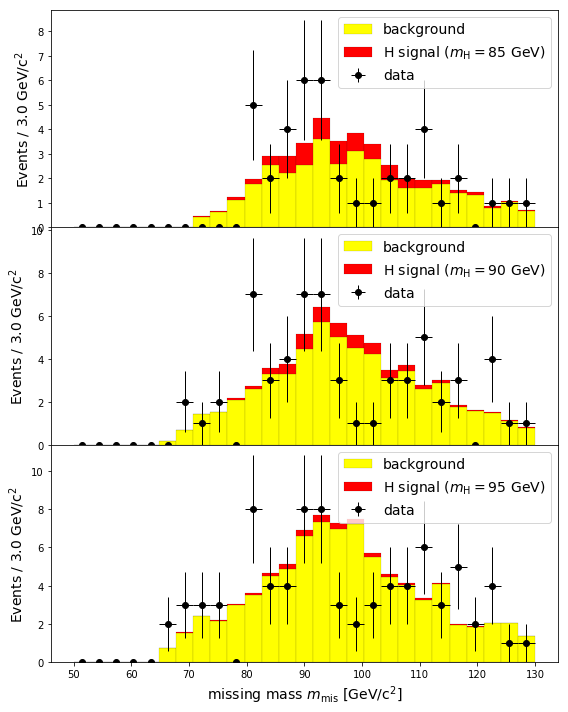

In [10]:
reload(pl)
path = 'C:\Users\jonas\OneDrive\ETH\StatMet\Project\plots\VariableDists_' 
#ensure_dir(file_path=path)

save_path = path+variable
pl.BkgSigHistos(backgrounds=bkgModels,signals=sigModels,datas=data_histModels,variable_binning=binning,
                x_label=[x_name,x_unit],
                savepath=None)#save_path)

## The Log-likelihood ratio we define to be

$$
    -2 \ln (Q(m_H)) = 2 s_{tot} - 2 \sum_{i=1}^{N_{bins}} N_i \ln \left( 1 + \frac{s_i(m_H)}{b_i} \right).
$$

In [11]:
Nexp = 10000
llr_85 = stat.LogLikRatio(background=bkgModels[0],signal=sigModels[0],N_experiments=Nexp)
llr_90 = stat.LogLikRatio(background=bkgModels[1],signal=sigModels[1],N_experiments=Nexp)
llr_95 = stat.LogLikRatio(background=bkgModels[2],signal=sigModels[2],N_experiments=Nexp)

llr_obs = stat.LogLikRatiosObserved(backgrounds=bkgModels,signals=sigModels,datas=data_histModels)

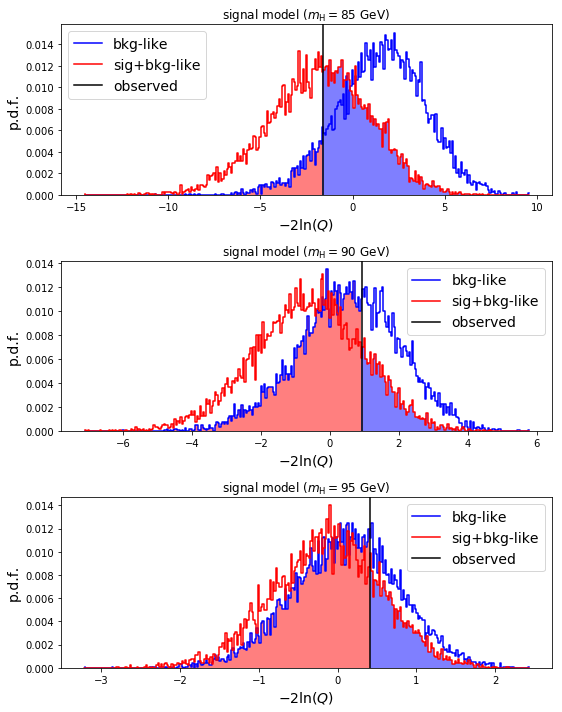

[[0.0906, 0.50070000000000003], [0.57659999999999989, 0.17469999999999999], [0.65719999999999967, 0.22740000000000005]]


In [12]:
path = 'C:\Users\jonas\OneDrive\ETH\StatMet\Project\plots\loglikeliratio_'
#ensure_dir(file_path=path)
save_path = path+variable
reload(pl)

CLlist, QuantileList_b, QuantileList_sPlusb = pl.LogLikRatioPlots([llr_85,llr_90,llr_95],Nbins=300,obs=llr_obs,
                            savepath=None)#save_path)
print CLlist

$$CL_s = \frac{CL_{s+b}}{CL_b} = \frac{CL_{s+b}}{1-(1-CL_b)}$$

In [13]:
CLs = [entry[1]/(1-entry[0]) for entry in CLlist]
print CLs

print "Confidence level CL >= "
for i in xrange(len(CLs)):
    print "    ", 1 - CLs[i]


[0.55058280184737196, 0.41261218705715624, 0.66336056009334843]
Confidence level CL >= 
     0.449417198153
     0.587387812943
     0.336639439907


# 2D 

## Variable Correlations

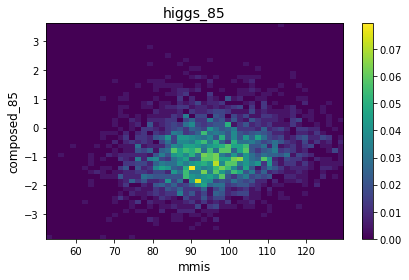

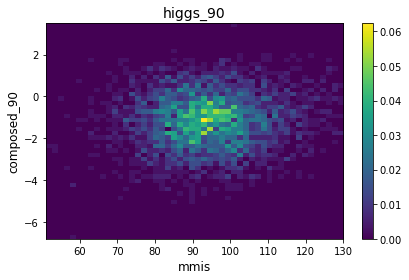

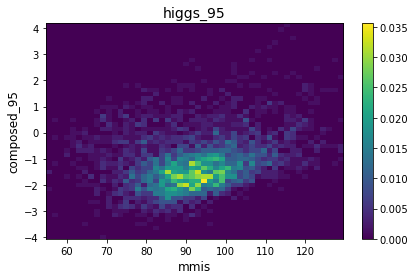

Background and data distribution are printed for composed 85 GeV Higgs. For the other composed variables, choose them instead of composed as variable.


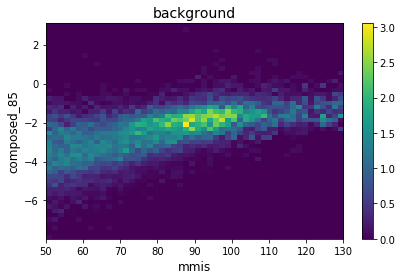

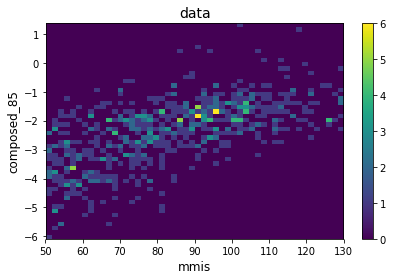

"\npl.TwoDHist(var1='btag1',var2='btag2',\n            framesMC_HiggsModels=[SelectionCut(dataframe=entry) for entry in framesMC_HiggsModels], # could use SelectionCut(frame) for each instead\n            NoHiggs=SelectionCut(NoHiggs), data=SelectionCut(data), \n            framesMC_HiggsModelsNames=framesMC_HiggsModelsNames,\n            savepath=save_path+'afterCut', bins=(50,50))\n\npl.TwoDHistFull(var1='mmis',var2='composed',\n            framesMC_HiggsModels=[sig_85,sig_90,sig_95], # could use SelectionCut(frame) for each instead\n            frames_NoHiggs=[bkg_85,bkg_90,bkg_95], frames_data=[data_85,data_90,data_95], \n            framesMC_HiggsModelsNames=framesMC_HiggsModelsNames,\n            savepath=save_path, bins=(7,7))\n"

In [14]:
path = 'C:\Users\jonas\OneDrive\ETH\StatMet\Project\plots\Corr_' #'/home/janik/StatMethods/Project/plots/loglikeliratio/' 
#ensure_dir(file_path=path)
save_path = path
reload(pl)
# Visualisation

pl.TwoDHist(var1='mmis',var2='composed',
            framesMC_HiggsModels=framesMC_HiggsModels, # could use SelectionCut(frame) for each instead
            NoHiggs=NoHiggs, data=data, 
            framesMC_HiggsModelsNames=framesMC_HiggsModelsNames,
            savepath=None,#save_path, 
            bins=(50,50))
"""
pl.TwoDHist(var1='btag1',var2='btag2',
            framesMC_HiggsModels=[SelectionCut(dataframe=entry) for entry in framesMC_HiggsModels], # could use SelectionCut(frame) for each instead
            NoHiggs=SelectionCut(NoHiggs), data=SelectionCut(data), 
            framesMC_HiggsModelsNames=framesMC_HiggsModelsNames,
            savepath=save_path+'afterCut', bins=(50,50))

pl.TwoDHistFull(var1='mmis',var2='composed',
            framesMC_HiggsModels=[sig_85,sig_90,sig_95], # could use SelectionCut(frame) for each instead
            frames_NoHiggs=[bkg_85,bkg_90,bkg_95], frames_data=[data_85,data_90,data_95], 
            framesMC_HiggsModelsNames=framesMC_HiggsModelsNames,
            savepath=save_path, bins=(7,7))
"""


## By-eye selection cut

In [15]:
def GetHistogram_TwoD (df, column1, column2, binning) :
    return np.histogram2d(df[column1],
                        df[column2],
                        bins = binning,
                        weights=df['weight'])[0]


var1 = 'mmis'
var2 = 'composed'

if type(binning) == np.ndarray:
    binning = [binning,binning,binning]
mH_hypos = [85,90,95] 

bkgModels = []
sigModels = [] 
data_histModels = [] 

binning1 = var_dict[var1]['binning']
binning2 = var_dict[var2]['binning']
binning = (6,6)#(10,10)#binning=[binnning1,binning2]))

# alternatively for by-eye
for i,sigframe in enumerate(framesMC_HiggsModels) :
    #for var in [var1,var2]:
    if var1 == 'composed':
            var1 += '_' +str(mH_hypos[i])
    if var2 == 'composed':
            var2 += '_' +str(mH_hypos[i])
    try:bkg = np.zeros(binning)
    except: bkg = np.zeros((len(binning1)-1, len(binning2)-1))
    for dataframe in framesMC_NoHiggs :            
        df = SelectionCut(dataframe=dataframe, mH_hypo=mH_hypos[i])
        bkg += GetHistogram_TwoD(df=df,
                             column1=var1,column2=var2,
                                       binning=binning)
        bkgModels.append(bkg)
    
    df = SelectionCut(dataframe=sigframe, mH_hypo=mH_hypos[i])
    sigModels.append(GetHistogram_TwoD(df=df,
                             column1=var1, column2=var2,
                                       binning=binning))
    
    df = SelectionCut(dataframe=data, mH_hypo=mH_hypos[i])
    data_histModels.append(GetHistogram_TwoD(df=df,
                             column1=var1,column2=var2,
                                       binning=binning))

    print "# data events in model %i: %i" %(mH_hypos[i],sum(sum(data_histModels[i])))


# data events in model 85: 41
# data events in model 90: 60
# data events in model 95: 81


## Boosted decision trees selection cut


In [16]:
data_85 = pd.read_csv('data_85')
data_90 = pd.read_csv('data_90')# (2)')
data_95 = pd.read_csv('data_95')

bkg_85 = pd.read_csv('bkg_85')
bkg_90 = pd.read_csv('bkg_90')# (2)')
bkg_95 = pd.read_csv('bkg_95')

sig_85 = pd.read_csv('sig_85')
sig_90 = pd.read_csv('sig_90')# (2)')
sig_95 = pd.read_csv('sig_95')

for frame in [data_85,data_90,data_95,bkg_85,bkg_90,bkg_95,sig_85,sig_90,sig_95]:
    frame = add_composed_var(frame)

### search for good cuts in composed variable

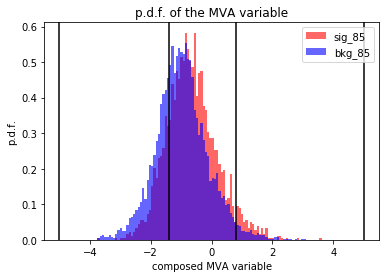

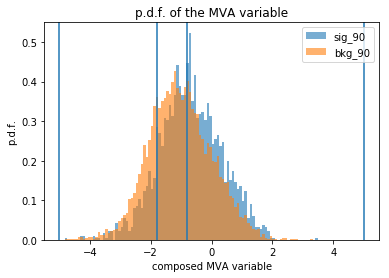

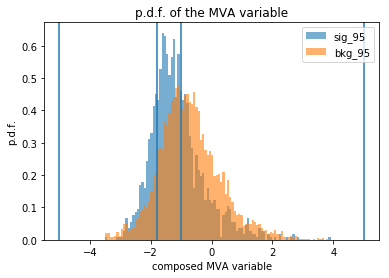

In [17]:
bims=100

c,b,_ =plt.hist(sig_85['composed_85'], alpha=.6, normed=True, bins=bims,label='sig_85', color='red')
plt.hist(bkg_85['composed_85'], bins=b, alpha=.6, normed=True, label='bkg_85',color='blue')
for p in np.array([-5.,-1.4,0.8,5.]):
    plt.axvline(p, color='black')
plt.legend()
plt.xlabel('composed MVA variable')
plt.ylabel('p.d.f.')
plt.title('p.d.f. of the MVA variable')
plt.savefig('C:\Users\jonas\OneDrive\ETH\StatMet\Project\plots\CutsOnMVA')
#plt.hist(data_85['composed_85'], bins=b, alpha=.3, normed=True)
plt.show()

c,b,_ =plt.hist(sig_90['composed_90'], alpha=.6, normed=True, bins=bims, label='sig_90')
plt.hist(bkg_90['composed_90'], bins=b, alpha=.6, normed=True, label='bkg_90')
for p in np.array([-5.,-1.8,-0.8,5.]):
    plt.axvline(p)
plt.xlabel('composed MVA variable')
plt.ylabel('p.d.f.')
plt.title('p.d.f. of the MVA variable')
#plt.hist(data_90['composed_90'], bins=b, alpha=.3, normed=True)

plt.legend()
plt.show()

c,b,_ =plt.hist(sig_95['composed_95'], alpha=.6, normed=True, bins=bims, label='sig_95')
plt.hist(bkg_95['composed_95'], bins=b, alpha=.6, normed=True, label='bkg_95')
for p in np.array([-5.,-1.8,-1,5.]):
    plt.axvline(p)
plt.xlabel('composed MVA variable')
plt.ylabel('p.d.f.')
plt.title('p.d.f. of the MVA variable')
#plt.hist(data_95['composed_95'], bins=b, alpha=.3, normed=True)

plt.legend()
plt.show()




In [18]:
def GetHistogram_TwoD (df, column1, column2, binning) :
    return np.histogram2d(df[column1],
                        df[column2],
                        bins = binning,
                        weights=df['weight'])[0]


var1 = 'mmis'
var2 = 'composed'

if type(binning) == np.ndarray:
    binning = [binning,binning,binning]
mH_hypos = [85,90,95] 

bkgModels = []
sigModels = [] 
data_histModels = [] 

binning1 = var_dict[var1]['binning']
binning2 = var_dict[var2]['binning']
binning = [(7,6),(9,9),(7,4)] 
#(10,10)#binning=[binnning1,binning2]))#
#binning = [(14,3),(18,2),(14,1)]
binning = [(np.linspace(50,130,28),np.array([-5.,-1.4,0.8,5.])) , (np.linspace(50,130,28),np.array([-5.,-1.8,-0.8,5.])), (np.linspace(50,130,28),np.array([-5.,-1.8,-1.,5.]))]
for i,sigframe in enumerate([sig_85,sig_90,sig_95]) :
    #for var in [var1,var2]:
    if var1 == 'composed':
            var1 += '_' +str(mH_hypos[i])
    if var2 == 'composed':
            var2 += '_' +str(mH_hypos[i])
    bkg = GetHistogram_TwoD(df=[bkg_85,bkg_90,bkg_95][i],
                             column1=var1,column2=var2,
                                       binning=binning[i])
    bkgModels.append(bkg)
    
    dat = GetHistogram_TwoD(df=[data_85,data_90,data_95][i],
                             column1=var1, column2=var2,
                                       binning=binning[i])
    
    data_histModels.append(dat)
    sig = GetHistogram_TwoD(df=sigframe,
                             column1=var1, column2=var2,
                                       binning=binning[i])
    sigModels.append(sig)
    

    print "# data events in model %i: %i" %(mH_hypos[i],sum(sum(data_histModels[i])))

# data events in model 85: 32
# data events in model 90: 27
# data events in model 95: 10


### Throw MC toys & calculate log likelihood ratios

In [19]:
reload(stat)

Nexp = 10000
llr_85 = stat.LogLikRatio_TwoD(background=bkgModels[0],signal=sigModels[0],N_experiments=Nexp)
print '85 done'
llr_90 = stat.LogLikRatio_TwoD(background=bkgModels[1],signal=sigModels[1],N_experiments=Nexp)
print '90 done'
llr_95 = stat.LogLikRatio_TwoD(background=bkgModels[2],signal=sigModels[2],N_experiments=Nexp)
print '95 done'

llr_obs = stat.LogLikRatioObserved_TwoD(bkgModels=bkgModels,signals=sigModels,data_histModels=data_histModels, emptyCalc=True)

print llr_obs

85 done
90 done
95 done
2 out of 243 bins where empty.
[4.5906693379069026, -1.1704012777135091, 0.3347866529665956]


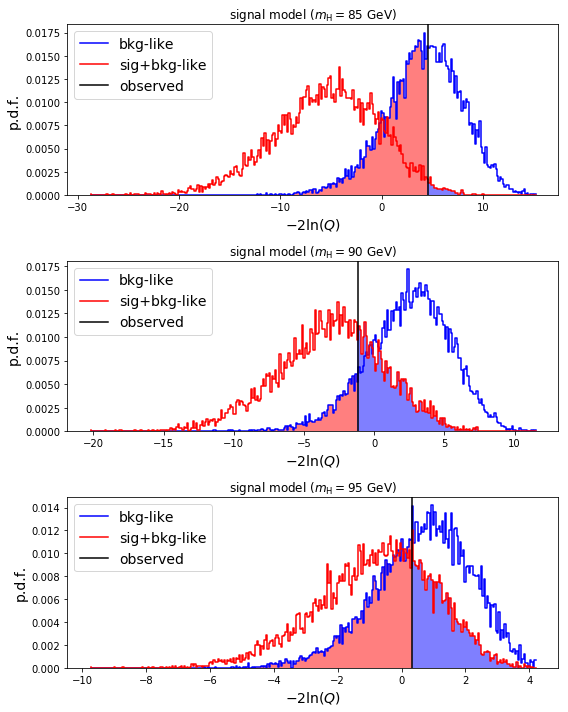

[[0.49890000000000018, 0.019199999999999995], [0.10379999999999999, 0.32769999999999988], [0.37369999999999987, 0.29540000000000011]]
[[4.3047107510138005, [0.4748005932762176, 7.8400124350792666], [-3.9443265118056132, 10.933401408636549]], [2.5810755392341136, [-0.50069461339690591, 5.3440418829722702], [-4.1138044475160314, 7.7882044178175605]], [0.74522802625284257, [-0.84426969725523549, 2.1477260175834996], [-2.6675170859850885, 3.2697244106480241]]]
[[-5.2700646433301621, [-10.720321406264418, -0.26172059090408695], [-16.317882406034737, 4.0101022773416801]], [-2.9448571482421961, [-6.9830387275518095, 0.56198474957930955], [-11.127488243159043, 3.9625587111031919]], [-0.70401989812216925, [-2.6675170859850885, 1.0257276245189733], [-4.7712640729810731, 2.3814756828052754]]]


In [20]:
reload(stat)
reload(pl)

CLlist, Quantiles_b, Quantiles_sPlusb  = pl.LogLikRatioPlots([llr_85,llr_90,llr_95],Nbins=300,obs=llr_obs,savepath=save_path)
print CLlist
print Quantiles_b
print Quantiles_sPlusb

## Confidence levels


In [21]:
CLs = [entry[1]/(1-entry[0]) for entry in CLlist]
print CLs

#print "binning = ", binning
print "Confidence level CL >= "
for i in xrange(len(CLs)):
    print "    ", 1 - CLs[i]

[0.038315705448014367, 0.36565498772595389, 0.47165894938527875]
Confidence level CL >= 
     0.961684294552
     0.634345012274
     0.528341050615


## Print data to use it in other code

In [22]:
print CLlist
print Quantiles_b
print Quantiles_sPlusb


[[0.49890000000000018, 0.019199999999999995], [0.10379999999999999, 0.32769999999999988], [0.37369999999999987, 0.29540000000000011]]
[[4.3047107510138005, [0.4748005932762176, 7.8400124350792666], [-3.9443265118056132, 10.933401408636549]], [2.5810755392341136, [-0.50069461339690591, 5.3440418829722702], [-4.1138044475160314, 7.7882044178175605]], [0.74522802625284257, [-0.84426969725523549, 2.1477260175834996], [-2.6675170859850885, 3.2697244106480241]]]
[[-5.2700646433301621, [-10.720321406264418, -0.26172059090408695], [-16.317882406034737, 4.0101022773416801]], [-2.9448571482421961, [-6.9830387275518095, 0.56198474957930955], [-11.127488243159043, 3.9625587111031919]], [-0.70401989812216925, [-2.6675170859850885, 1.0257276245189733], [-4.7712640729810731, 2.3814756828052754]]]


# Results:

## winner:

binning = [(np.linspace(50,130,28),np.array([-5.,-1.4,0.8,5.])) , (np.linspace(50,130,28),np.array([-5.,-1.8,-0.8,5.])), (np.linspace(50,130,28),np.array([-5.,-1.8,-1.,5.]))]


    Confidence level CL >= 
     0.961754104926
     0.63456405694
     0.515910192215
     

## out of:
    
binning = [(np.linspace(50,130,14),np.array([-5.,-.1,5.])),(np.linspace(50,130,28),np.array([-5.,-1.,5.])),(np.linspace(50,130,14),np.array([-5.,-1.,5.]))] 
     
     Confidence level CL >= 
     0.627515400411
     0.498518831993
     0.432560077789
     
binning = [(np.linspace(50,130,28),np.array([-5.,-.7,1.,5.])),(np.linspace(50,130,28),np.array([-5.,-.3,5.])),(np.linspace(50,130,28),np.array([-5.,-1.8,-1.,5.]))] 

    Confidence level CL >= 
     0.867198335645
     0.311822510384
     0.52351902392
     
binning = [(np.linspace(50,130,14),np.array([-5.,-1.,5.])),(np.linspace(50,130,14),np.array([-5.,-1,5.])),(np.linspace(50,130,14),np.array([-5.,-1.,5.]))] 

    Confidence level CL >= 
     0.784446138765
     0.466722830666
     0.437692955375


binning = [(np.linspace(50,130,28),np.array([-5.,-1.,5.])),(np.linspace(50,130,28),np.array([-5.,-1,5.])),(np.linspace(50,130,28),np.array([-5.,-1.,5.]))] 

    Confidence level CL >= 
     0.791839859987
     0.495279516283
     0.475018532246
     
binning = [(np.linspace(50,130,14),np.array([-5.,-2,-1,0.1,5.])),(np.linspace(50,130,28),np.array([-5.,-1.8,-0.8,.7,5.])),(np.linspace(50,130,14),np.array([-5.,-1.6,-0.8,0,5.]))] 

    Confidence level CL >= 
     0.635538790906
     0.509347258486
     0.396903225806

binning = [(np.linspace(50,130,14),np.linspace(-4,4,7)),(np.linspace(50,130,28),np.array([-5.,-1.8,-0.4,5.])),(np.linspace(50,130,14),np.array([-5.,-1.6,-0.8,0,1.8,5.]))] 

    Confidence level CL >= 
     0.848068181818
     0.476338729763
     0.400889121339
     
binning = [(np.linspace(50,130,28),np.linspace(-4,4,7)),(np.linspace(50,130,14),np.array([-5.,-1.8,-0.8,5.])),(np.linspace(50,130,28),np.array([-5.,-1.6,-0.8,0,1.8,5.]))] 
     
    Confidence level CL >= 
     0.87096403539
     0.610092252973
     0.408384897083
     
binning = [(np.linspace(50,130,28),np.linspace(-4,4,9)),(np.linspace(50,130,14),np.array([-5.,-1.6,-0.6,5.])),(np.linspace(50,130,28),np.array([-5.,-1.6,-1.,5.]))] 

    Confidence level CL >= 
     0.723699182787
     0.500732984293
     0.523329129887
     
binning = [(np.linspace(50,130,28),np.linspace(-4,4,4)),(np.linspace(50,130,14),np.array([-5.,-2,-1,5.])),(np.linspace(50,130,28),np.array([-5.,-1.4,-1.,5.]))] 

    Confidence level CL >= 
     0.95799887997
     0.486776946581
     0.498662470496
    
     
90 .1: 0.369854597583 (linspace 14)
90 -2: 0.551464897734 (linspace 28)
90 -1.8 & -0.8: 0.63482831898 (linspace 28)


binning = [(7,7),(8,8),(7,4)]

    Confidence level CL >= 
     0.952580028667
     0.026902690269
     0.3249055812
     
binning = [(8,6),(8,6),(7,3)]     

    Confidence level CL >= 
     0.838144867118
     0.016
     0.410908646203

binning =  [(8, 7), (2, 2), (6, 3)]

    Confidence level CL >= 
     0.938706400271
     0.162020730603
     0.127041742287

binning =  [(7, 8), (5, 4), (5, 3)]

    Confidence level CL >= 
     0.929531705131
     0.030703070307
     0.268274383708
     
binning =  [(7, 6), (9, 9), (7, 4)]

    Confidence level CL >= 
     0.844532554257
     0.03971985993
     0.324955492722
     
binning =  [(28,3)]

    Confidence level CL >= 
     0.550010022049
     0.14181198637
     0.0339
     
binning = [(15,4),(15,4),(15,4)]

    Confidence level CL >= 
     0.1064
     0.046704670467
     0.749083063646
     
binning =  [(28, 1), (28, 1), (28, 1)]

    Confidence level CL >= 
     0.862589928058
     0.432515663162
     0.443015521064
     
binning =  [(28, 2), (28, 2), (28, 2)]

    Confidence level CL >= 
     0.95981765997
     0.183398653402
     0.436894285396
     
     
binning =  [(28, 3), (28, 3), (28, 3)]

    Confidence level CL >= 
     0.55825145378
     0.139593145606
     0.0312062412483
     
binning =  [(14, 2), (14, 2), (14, 2)]

    Confidence level CL >= 
     0.963696369637
     0.109874686717
     0.554731224782

linspace 28*2
    0.940685820204
     0.281580016247
     0.720828215476
     
